# <center>Entrenar y evaluar una red neuronal convolucional para resolver un problema de clasificación de imágenes</center>

<div style="background-color: #fdebd0 ">
<b>Este TP tiene 3 objetivos:</b><br>
- Describir conceptos vinculados al entrenamiento y uso de <i>ConvNets</i> para la clasificación de imágenes<br>
- Familiarizarse con la librería PyTorch<br>
- Reproducir un protocolo para entrenar una red neuronal convolucional y clasificar imágenes.</div>


PyTorch es una librería de aprendizaje automático de código abierto para Python, desarrollada principalmente por el grupo de investigación de inteligencia artificial de Facebook. Dentro de PyTorch, el paquete <code>torchvision</code> consiste en conjuntos de datos populares, arquitecturas de modelos y transformaciones de imágenes comunes para la visión artificial.

En la primera parte del trabajo práctico, utilizaremos el conjunto de datos CIFAR10 disponible en <code>torchvision</code>.  Este dataset sirve para aprender a resolver un problema de clasificación con 10 clases: 'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño: https://www.cs.toronto.edu/~kriz/cifar.html

El código está basado en el tutorial de PyTorch siguiente: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

<img src="cifar10.png"></img>

Para resolver el problema de clasificación de imágenes, seguiremos los siguientes pasos:

- Cargar y normalizar los conjuntos de datos de entrenamiento y pruebas utilizando CIFAR10.
- Configurar una red neuronal de convolución
- Definir una función de pérdida
- Optimizar la red sobre los datos de entrenamiento
- Probar el rendimiento de la red con los datos de test

Por cada paso, se solicita responder a una serie de preguntas.

## 1. Cargar y normalizar el dataset CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Cuál es el tamaño del dataset de entrenamiento y del dataset de test? (Imprimir el resultado con la función <code>print</code>)<br>
2) ¿Por qué el parametro <code>shuffle</code> se configura "True" para el dataset de entrenamiento y "False" para el dataset de test? ¿De qué sirve este parametro?<br>


In [2]:
print('el tamaño del dataset de entrenamiento es :',len(trainset))
print('el tamaño del dataset de prueba es: ',len(testset))

el tamaño del dataset de entrenamiento es : 50000
el tamaño del dataset de prueba es:  10000


shuffle recombina la data que se envia en cada epoca, de esta forma se elimina la posibilidad de que el orden de los datos afecte los resultados. No se ocupa al momento de tomar datos de prueba pues se requiere asegurar que se tomen todos los datos.

El código siguiente permite mostrar imagenes aleatorias del dataset de entrenamiento y su etiqueta real:

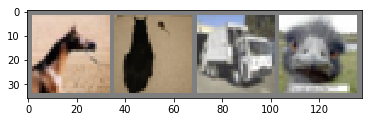

horse   cat truck  bird


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imagesFromBatches(iterator,quantity):
    dataiter = iter(iterator)
    images, labels = dataiter.next()    
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(quantity)))
    return (images,labels)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Configurar la CNN

In [5]:
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().cuda()

summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Cuántas capas tiene esta ConvNet?<br>
2) Explicar los parametros de cada capa. ¿Cuántos filtros se utilizan en las capas de convolución? ¿Cuál es el tamaño de los filtros? <br>
3) ¿Cuál es la diferencia entre la función <code>init</code> y <code>forward</code>?<br>
4) ¿De qué sirve la función view()? Explicar sus parametros.<br>
5) ¿Cuántos paramétros en total se tiene que aprender con esta ConvNet? <br>
6) ¿Por qué se utiliza la función <code>conv2d</code> aunque tenemos imagenes con 3 canales?
</div>

<br>1) 2 capas de convolucion, 2 capas de pooling y 3 capas de transformacion lineal. En total 7 capas </br>
<br>2) se tiene:</br>
<br>Conv1: recive una imagen de 3 canales, sale una imagen de 6 canales y define los filtros de dimensiones 5x5. </br>
<br>Pool: define el tamaño del pooling y el stride que usa.</br>
<br>Conv2: recive una imagen de 6 canales, entrega una imagen de 16 canales y define los filtros de dimensiones 5x5</br>
<br>fc1: realiza una transformacion lineal, recive 400 caracteristicas y entrega 120 caracteristicas</br>
<br>fc2: realiza una transformacion lineal, recive 120 caracteristicas y entrega 84 caracteristicas.</br>
<br>fc3: realiza una transformacion lienal, recive 84 caracteristicas y entrega 10 caracteristicas correspondientes a las 10 clases de objetos que se busca detectar.</br>
<br>3)Init define las funciones que se usaran posteriormente, en cambio forward le pasa la data a las funciones y determina el orden en que se ejecutan.</br>
<br>4) transforma la imagen de 16x5x5 en un vector de una dimension.el primer parametro define la forma de la salida y el segundo parametro define la forma de la entrada </br>
<br>5) 62,006 parametros</br>
<br>6) se separan los canales y el filtro recorre la imagen en las dimensiones x,y por lo tanto se requiere un filtro de 2 dimenciones</br>

## 3. Entrenar la CNN

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.cuda())
        loss = criterion(outputs.cuda(), labels.cuda())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.251
[1,  4000] loss: 1.890
[1,  6000] loss: 1.691
[1,  8000] loss: 1.590
[1, 10000] loss: 1.537
[1, 12000] loss: 1.459
[2,  2000] loss: 1.402
[2,  4000] loss: 1.359
[2,  6000] loss: 1.345
[2,  8000] loss: 1.338
[2, 10000] loss: 1.323
[2, 12000] loss: 1.280
[3,  2000] loss: 1.219
[3,  4000] loss: 1.226
[3,  6000] loss: 1.205
[3,  8000] loss: 1.191
[3, 10000] loss: 1.200
[3, 12000] loss: 1.201
[4,  2000] loss: 1.107
[4,  4000] loss: 1.143
[4,  6000] loss: 1.128
[4,  8000] loss: 1.114
[4, 10000] loss: 1.115
[4, 12000] loss: 1.118
[5,  2000] loss: 1.043
[5,  4000] loss: 1.051
[5,  6000] loss: 1.053
[5,  8000] loss: 1.066
[5, 10000] loss: 1.072
[5, 12000] loss: 1.030
Finished Training


- Ver la video: https://www.youtube.com/watch?v=ErfnhcEV1O8 - A Short Introduction to Entropy, Cross-Entropy and KL-Divergence

- Leer: http://ruder.io/optimizing-gradient-descent/index.html - An overview of gradient descent optimization algorithm

<div style="background-color: #fdebd0 ">
<b>Preguntas</b><br>
1) ¿Qué hace la función <code>CrossEntropyLoss</code>? Qué devuelve? Con qué otra función se podría reemplazar <code>CrossEntropy</code>?<br>
2) ¿Cuál es la diferencia principal entre los métodos de optimización Gradient Descent, Stochastic Gradient Descent y Mini-Batch Gradient Descent?<br>
3) ¿En nuestro ejemplo, qué método utilizamos? En qué parte del código se podría cambiar el tamaño del batch?<br>
4) ¿Qué metafora podemos utilizar para entender la idea del parametro <code>momentum</code>?<br>
5) ¿Podría ser útil aumentar el número de epoch? ¿Por qué? De qué sirve este parametro?

</div>

<br>a)Calcula una funcion de perdida usando crossentropy. Entrega un escalar.La libreria de torch tiene disponible otras funciones de perdida, estas son: L1Loss, MSELoss, CTCLoss, entre otras</br>

## 4. Evaluar la CNN

Tomamos 4 ejemplos del dataset de test:

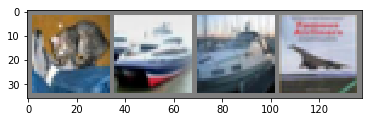

  cat  ship  ship plane


In [12]:
BatchSize=4

images,labels= imagesFromBatches(testloader,BatchSize)

Clasificamos estas 4 imágenes con nuestra CNN: 

In [15]:
outputs = net(images.cuda())

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   dog  deer horse


<div style="background-color: #fdebd0 ">
<b>Pregunta</b><br>
1) ¿Cuál es el rendimiento del modelo entrenado sobre estos primeros ejemplos?
<br>
solo adivinó 1 de 4, 25% de presicion
</div>

Calculamos el rendimiento de nuestra CNN sobre todos los datos del training set:

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


Miramos el rendimiento de la CNN calculando su exactitud según cada etiqueta:

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels.cuda()).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 69 %
Accuracy of   car : 70 %
Accuracy of  bird : 47 %
Accuracy of   cat : 36 %
Accuracy of  deer : 51 %
Accuracy of   dog : 50 %
Accuracy of  frog : 69 %
Accuracy of horse : 63 %
Accuracy of  ship : 61 %
Accuracy of truck : 84 %


<div style="background-color: #fdebd0 ">
<b>Preguntas:</b><br>
1) ¿Qué paramétros podrían modificar para tratar de mejorar el rendimiento de la CNN? <br>
2) ¿Cómo se llama la arquitectura de CNN que hemos utilizado? (ver slides del curso y https://medium.com/@sidereal/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5 y https://adeshpande3.github.io/The-9-Deep-Learning-Papers-You-Need-To-Know-About.html)<br>
3) ¿Qué pasa si tratan de agregar más filtros en la segunda capa de convolución? <br>
4) ¿Qué pasa si trata de agregar una tercera capa de convolución y pooling? <br>
5) ¿En la literatura, qué arquitecturas CNN permiten obtener mejores rendimiento que la arquitectura LeNet-5? Cuál es el limite de estas arquitecturas? <br>
</div>

<div style="background-color: #fdebd0 ">
<b>T.P</b><br>
Optimizar una CNN para resolver el problema asociado al dataset Fashion-MNIST (https://pytorch.org/docs/stable/torchvision/datasets.html#fashion-mnist). <br>

1) ¿La arquitectura LeNet-5 es mejor que Random Forest? Comparar el rendimiento obtenido con lo obtenido por el algoritmo RandomForest (con 50 estimadores).
</div>